# Inclus AI – Demo Feature Extraction approach

Make sure that you have installed all required packages to run this notebook

In [187]:
import pandas as pd
from openai import AzureOpenAI
import numpy as np
import matplotlib.pyplot as plt

# this part is require for testing of hallucination
import torch
from selfcheckgpt.modeling_selfcheck import SelfCheckMQAG, SelfCheckBERTScore, SelfCheckNgram
import spacy
!pip install selfcheckgpt
!python -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm")

# set up your azure client and don't forget to change api key and endpoint
client = AzureOpenAI(
    api_key="[API KEY]",
    api_version="2024-02-15-preview",
    azure_endpoint="[END POINT]" 
)

In [190]:
# read data provided by Inclus
df = pd.read_excel("inclusData.xlsx") 
# leave only those rows that have textual comment
df = df.dropna()

# format all comments as a list
risk_data_1 = ""
for j, row in enumerate(df[["Comment", "Item", "Dimension", "Answer",]].values[:38, :]):
    risk_data_1 += f"{j+1}. Risk type: '{row[1]}'. Dimension: {row[2]}. Grade: {row[-1]} Comment: {row[0]} \n"

# provide some context for ChatGpt
prompt_engineering_majick = 'Assistant is an expert in risk analysis (it can judge about impact and probability of risk based on the set of comments) and natural language processing expert, so it can evaluate parameters associated with text features. It can make conclusions only based on the provided comments. If assistant is not sure in the answer, it can return text "None" '
task_context = f'The assistant would be provided a list with indexes, risk type and comment it should answer on posed benchmark question. Do not add any additional text except for required output format.'
company_context = 'Inclus is a Finnish scaleup company that provides a platform for doing collaborative risk analysis.'
data_context = 'The data that is provided below is gathered from multiple people within Inclus and concerns multiple risk events. Treat each comment equally.'

# formulate benchmark question
benchmark_question = """
Find embedding for all comments in the provided list (for all 38). Only semantic can take neutral value. 
Each comment should be accessed next features with regards to assoicated risk type: objectivity of author(positive/negative), 
argumentative(positive/negative), list of top 5 or less keywords that are not common words (use words only from comment), 
semantic of the comment(positive/neutral/negative), is author is expert in risk analysis (positive/negative). 

The output should be provided in next format: 
index. content of original comment
expert=positive/negative*list of keywords=[keyword1, keyword2...]*semantic=positive/neutral/negative*objectivity=positive/negative*argumentative=positive/negative

Only options listed in the output format are allowed for embedding evaluation.

Assistant should interpret objectivity as: "if the authors comment correspond to grade, where 1 is really small and 5 is really big impact/likelyhood
Argumentative means that the author argument is overall good and discusses risk type
Semantic means if the overall comment sounds negative, positive or neutral
Expert means if the author sounds like expert in risk analysis
"""

# combine all context with comments
context_for_GPT = [prompt_engineering_majick,
task_context,
company_context,
data_context,
risk_data_1]
system_content = '\n'.join(context_for_GPT) 

print('\n'.join(context_for_GPT[:-1]))

Assistant is an expert in risk analysis (it can judge about impact and probability of risk based on the set of comments) and natural language processing expert, so it can evaluate parameters associated with text features. It can make conclusions only based on the provided comments. If assistant is not sure in the answer, it can return text "None" 
The assistant would be provided a list with indexes, risk type and comment it should answer on posed benchmark question. Do not add any additional text except for required output format.
Inclus is a Finnish scaleup company that provides a platform for doing collaborative risk analysis.
The data that is provided below is gathered from multiple people within Inclus and concerns multiple risk events. Treat each comment equally.


In [191]:
print(benchmark_question) 


Find embedding for all comments in the provided list (for all 38). Only semantic can take neutral value. 
Each comment should be accessed next features with regards to assoicated risk type: objectivity of author(positive/negative), 
argumentative(positive/negative), list of top 5 or less keywords that are not common words (use words only from comment), 
semantic of the comment(positive/neutral/negative), is author is expert in risk analysis (positive/negative). 

The output should be provided in next format: 
index. content of original comment
expert=positive/negative*list of keywords=[keyword1, keyword2...]*semantic=positive/neutral/negative*objectivity=positive/negative*argumentative=positive/negative

Only options listed in the output format are allowed for embedding evaluation.

Assistant should interpret objectivity as: "if the authors comment correspond to grade, where 1 is really small and 5 is really big impact/likelyhood
Argumentative means that the author argument is overall

In [192]:
# get result from ChatGPT
response = client.chat.completions.create(
    model="gpt-4-turbo",
    messages=[
        {"role": "system", "content": system_content},
        {"role": "user", "content": benchmark_question} # the first strict benchmark question is asked
    ]
)

In [209]:
# clean and parse output from ChatGPT
cleaned = []
for j, i in enumerate(response.choices[0].message.content.split("\n")):
    if i!='':
        cleaned.append(i)

comments = []
embedings = []

for i, j in enumerate(cleaned):
    if i%2 == 0:
        comments.append(j[3:])
    else:
        embedings.append(j)   

result = {
    'comment': comments,
    'expert':[],
    'list of keywords':[],
    'semantic':[],
    'objectivity':[],
    'argumentative':[]
}

# translate words to numbers
numerical = {
    'negative': -1,
    'neutral': 0,
    'positive': 1
}

for k, i in enumerate(embedings):
    for j in i.split('*'):
        inp = j.split("=")
        if inp[0] in ["dimension","list of keywords"]:
            result[inp[0]].append(inp[1][1:-1])
        else:
            result[inp[0]].append(numerical[inp[1]]) 

gpt_output = pd.DataFrame(result)
allowed_columns = ['expert','semantic','objectivity', 'argumentative']
gpt_output[allowed_columns]

,expert,semantic,objectivity,argumentative
0,1,1,1,1
1,1,1,1,1
2,-1,0,-1,-1
3,1,0,-1,1
4,1,1,-1,1
5,-1,0,1,-1
6,1,1,1,1
7,-1,-1,1,-1
8,1,0,-1,1
9,1,0,1,1


In [210]:
# read our assesment
numerical_features = ["expert", "semantic", "objectivity", "argumentative"]

df_embedings = pd.read_excel("inclusData_embeddings.xlsx") # have the xlsx shared by Juha in the same folder as this .ipynb file
df_embedings.dropna(inplace=True)
df_embedings.rename(columns={"expert (risk analysis)": "expert"}, inplace=True)

df_embedings[numerical_features][:38]

,expert,semantic,objectivity,argumentative
0,1.0,0.0,1.0,1.0
3,1.0,0.0,1.0,1.0
5,-1.0,0.0,1.0,1.0
6,-1.0,0.0,1.0,-1.0
7,1.0,1.0,1.0,1.0
8,-1.0,0.0,-1.0,-1.0
9,1.0,1.0,1.0,1.0
10,-1.0,0.0,1.0,-1.0
11,1.0,0.0,1.0,1.0
12,1.0,-1.0,1.0,1.0


In [212]:
acc = np.sum(gpt_output[numerical_features].values[:38] == (df_embedings[numerical_features]).values, axis=0)/38
for i, a in enumerate(acc):
    print(f"Accuracy of {numerical_features[i]}: {a*100}%")

Accuracy of expert: 71.05263157894737%
Accuracy of semantic: 44.73684210526316%
Accuracy of objectivity: 68.42105263157895%
Accuracy of argumentative: 71.05263157894737%


In [268]:
prompt_engineering_majick = 'Assistant is an expert in risk analysis (it can judge about impact and probability of risk based on the set of comments) and natural language processing expert, so it can evaluate parameters associated with text features. It can make conclusions only based on the provided comments. If assistant is not sure in the answer, it can return text "None" '
task_context = f'The assistant would be provided a list with indexes, risk type and comment it should answer on posed benchmark question. Do not add any additional text except for required output format.'
company_context = 'Inclus is a Finnish scaleup company that provides a platform for doing collaborative risk analysis.'
data_context = 'The data that is provided below is analysis of gathered from multiple people within Inclus and concerns multiple risk events. Treat each comment equally.'

benchmark_question = """For each comment (for all 38 comments) provide analysis that should discuss objectivity, argumentativity, expertise and semantic of the comment with detailed explanation.
Assistant should interpret objectivity as: "if the authors comment correspond to grade, where 1 is really small and 5 is really big impact/likelyhood
Argumentative means that the author argument is overall good and discusses risk type
Semantic means if the overall comment sounds negative, positive or neutral
Expert means if the author sounds like expert in risk analysis

Output should be provided in the next format:  
i. analysis: analysis with 2-3 sentences (at most). Assistant shouldnt add any additional information that it is not asked. 

Provide answer according to output format. The language style of the output should be exact and not vague.
"""

context_for_GPT = [prompt_engineering_majick,
task_context,
company_context,
data_context,
risk_data_1]
print('\n'.join(context_for_GPT[:-1]))

system_content = '\n'.join(context_for_GPT) # goes into the prompt in 'messages' part in line '{"role": "system", "content": system_content}' later


Assistant is an expert in risk analysis (it can judge about impact and probability of risk based on the set of comments) and natural language processing expert, so it can evaluate parameters associated with text features. It can make conclusions only based on the provided comments. If assistant is not sure in the answer, it can return text "None" 
The assistant would be provided a list with indexes, risk type and comment it should answer on posed benchmark question. Do not add any additional text except for required output format.
Inclus is a Finnish scaleup company that provides a platform for doing collaborative risk analysis.
The data that is provided below is analysis of gathered from multiple people within Inclus and concerns multiple risk events. Treat each comment equally.


In [269]:
print(benchmark_question)

For each comment (for all 38 comments) provide analysis that should discuss objectivity, argumentativity, expertise and semantic of the comment with detailed explanation.
Assistant should interpret objectivity as: "if the authors comment correspond to grade, where 1 is really small and 5 is really big impact/likelyhood
Argumentative means that the author argument is overall good and discusses risk type
Semantic means if the overall comment sounds negative, positive or neutral
Expert means if the author sounds like expert in risk analysis

Output should be provided in the next format:  
i. analysis: analysis with 2-3 sentences (at most). Assistant shouldnt add any additional information that it is not asked. 

Provide answer according to output format. The language style of the output should be exact and not vague.



In [270]:
response = client.chat.completions.create(
    model="gpt-4-turbo",
    messages=[
        {"role": "system", "content": system_content},
        {"role": "user", "content": benchmark_question} # the first strict benchmark question is asked
    ]
)

In [271]:
cleaned_1 = []
for i in response.choices[0].message.content.split('\n'):
    try:
        if len(i)>0 and i!=" ":
            cleaned_1.append(i.split(":")[1][1:])
    except:
        pass

print(cleaned_1[0])

risk_data_2 = ""
for j, row in enumerate(cleaned_1):
    temp = f"{j+1}. analysis:  {row}\n"
    risk_data_2 += temp

The comment is moderately objective as it aligns with the given grade by suggesting practical mitigation strategies for a mid-level IT risk. It is argumentative as it discusses prevention measures related to IT risk management. The semantic tone is neutral, focusing on procedural aspects. The commenter displays expertise by recommending specific tools and good habits.


In [272]:
prompt_engineering_majick = 'Assistant is an expert in risk analysis (it can judge about impact and probability of risk based on the set of comments) and natural language processing expert, so it can evaluate parameters associated with text features. It can make conclusions only based on the provided comments. If assistant is not sure in the answer, it can return text "None" '
task_context = f'The assistant would be provided a list with indexes, risk type and comment it should answer on posed benchmark question. Do not add any additional text except for required output format.'
company_context = 'Inclus is a Finnish scaleup company that provides a platform for doing collaborative risk analysis.'
data_context = 'The data that is provided below is analysis of comments gathered from multiple people within Inclus and concerns multiple risk events. Treat each comment equally.'

benchmark_question = """Based on the provided analysis of comments. Find embedding for each analysis in the provided list (for all 38). Only semantic can take neutral value. Each analysis comment should be accessed next features with regards to assoicated risk type: objectivity of author(positive/negative) is person over (overoptimistic or overpesimistic which is "negative" or realistic which is "positive"), argumentative(positive/negative) how well comment corresponds to risk type, 
semantic of the comment(positive/neutral/negative), is author expert in risk analysis (positive/negative). The output should be provided in next format: index. expert=positive/negative*semantic=positive/neutral/negative*objectivity=positive/negative*argumentative=positive/negative

Note that assistant should access not semantic of analysis, but of the original comment based on analysis."""

context_for_GPT = [prompt_engineering_majick,
task_context,
company_context,
data_context,
risk_data_2]

print('\n'.join(context_for_GPT[:-1]))

system_content = '\n'.join(context_for_GPT) 

Assistant is an expert in risk analysis (it can judge about impact and probability of risk based on the set of comments) and natural language processing expert, so it can evaluate parameters associated with text features. It can make conclusions only based on the provided comments. If assistant is not sure in the answer, it can return text "None" 
The assistant would be provided a list with indexes, risk type and comment it should answer on posed benchmark question. Do not add any additional text except for required output format.
Inclus is a Finnish scaleup company that provides a platform for doing collaborative risk analysis.
The data that is provided below is analysis of comments gathered from multiple people within Inclus and concerns multiple risk events. Treat each comment equally.


In [274]:
print(benchmark_question)

Based on the provided analysis of comments. Find embedding for each analysis in the provided list (for all 38). Only semantic can take neutral value. Each analysis comment should be accessed next features with regards to assoicated risk type: objectivity of author(positive/negative) is person over (overoptimistic or overpesimistic which is "negative" or realistic which is "positive"), argumentative(positive/negative) how well comment corresponds to risk type, 
semantic of the comment(positive/neutral/negative), is author expert in risk analysis (positive/negative). The output should be provided in next format: index. expert=positive/negative*semantic=positive/neutral/negative*objectivity=positive/negative*argumentative=positive/negative

Note that assistant should access not semantic of analysis, but of the original comment based on analysis.


In [ ]:
response = client.chat.completions.create(
    model="gpt-4-turbo",
    messages=[
        {"role": "system", "content": system_content},
        {"role": "user", "content": benchmark_question} # the first strict benchmark question is asked
    ]
)

# clean the output
gpt_output_1 = {'expert': [], 'semantic':[], 'objectivity':[], 'argumentative':[]}
for i in response.choices[0].message.content.split('\n'):
    temp = (i.split(".")[1][1:]).split("*")
    for t in temp:
        f, val =  t.split("=")
        gpt_output_1[f].append(numerical[val])

In [276]:
gpt_output_1 = pd.DataFrame(gpt_output_1)
gpt_output_1

,expert,semantic,objectivity,argumentative
0,1,0,1,1
1,1,0,1,1
2,1,0,1,1
3,1,1,1,-1
4,1,0,1,1
5,1,0,1,1
6,1,1,1,1
7,1,0,1,1
8,1,0,1,1
9,1,1,1,1


In [277]:
acc = np.sum(gpt_output[numerical_features].values[:38] == gpt_output_1.values, axis=0)/38

for i, a in enumerate(acc):
    print(f"Accuracy of {numerical_features[i]}: {a}")

Accuracy of expert: 0.7894736842105263
Accuracy of semantic: 0.5
Accuracy of objectivity: 0.7368421052631579
Accuracy of argumentative: 0.7368421052631579


In [278]:
acc = np.sum(df_embedings[numerical_features].values[:38] == gpt_output_1.values, axis=0)/38

for i, a in enumerate(acc):
    print(f"Accuracy of {numerical_features[i]}: {a}")

Accuracy of expert: 0.6052631578947368
Accuracy of semantic: 0.6842105263157895
Accuracy of objectivity: 0.7894736842105263
Accuracy of argumentative: 0.7631578947368421


In [243]:
gpt_output_1.to_excel("output.xlsx")  

# Finetuning: suggested approach

In [ ]:
finetuning = []
while len(finetuning)<15:
    rand_num = np.random.randint(0, 38)
    if rand_num not in finetuning:
        finetuning.append(rand_num)

finetuning = set(finetuning)
testing = list(set(np.arange(0, 38)) - finetuning)
finetuning = list(finetuning)

fine = df[["Comment", "Item", "Dimension", "Answer"]].values[:38, :][finetuning]
fine_embedings = df_embedings[numerical_features+["list of keywords (at most 5-10)"]].values[finetuning]

trans = {
    -1.0: "negative",
    0.0: "neutral",
    1.0: "positive"
}

def return_data(fine, fine_embedings):
    row = ''
    basic = '{"messages": [{"role": "system", "content": "Assistant is an expert in risk analysis (it can judge about impact and probability of risk based on the set of comments) and natural language processing expert, so it can evaluate parameters associated with text features. It can make conclusions only based on the provided comments. If assistant is not sure in the answer, it can return text None. The assistant would be provided a list with indexes, risk type and comment. Treat each comment equally.\n'
    for i in range(fine.shape[0]):
        row += basic
        row+= f'{i+1}. Risk type: {fine[i][1]}. Dimension: {fine[i][2]}. Comment: {fine[i][0]}\n'
        row+='"},{"role": "user", "content":"Find embedding for each comment in the provided list. Each comment should be accessed next features with regards to assoicated risk type: cohesion(positive/negative), objectivity of author(positive/negative) is author over pessimistic or positive, argumentative(positive/negative) is authors argument good in regards to risk type and dimension, list of top 5 or less keywords that are not common words (use words only from comment), semantic of the comment(positive/negative), is author is an expert in risk analysis (positive/negative). The output should be provided in next format: index. content of original comment\ncohesion=positive/negative*expert=positive/negative*list of keywords=[keyword1, keyword2...]*semantic=positive/neutral/negative*objectivity=positive/negative*argumentative=positive/negative\n]"},{"role": "assistant", "content": "'
        row+= f'1. {fine[i][0]}\n'
        row+= f'*expert={trans[fine_embedings[i][0]]}*list of keywords=[{fine_embedings[i][-1]}]*semantic={trans[fine_embedings[i][1]]}*objectivity={trans[fine_embedings[i][2]]}*argumentative={trans[fine_embedings[i][3]]}\n'
        row+='"}]}\n'

    return row

result_row = return_data(fine.copy(), fine_embedings.copy())
with open("training_set.jsonl", "w") as text_file:
    text_file.write(result_row)

result_row = return_data(fine[9:12].copy(), fine_embedings[9:12].copy())+return_data(fine[12:15].copy(), fine_embedings[12:15].copy())
with open("validation_set.jsonl", "w") as text_file:
    text_file.write(result_row)

client = AzureOpenAI(
    api_key="f2d812684f4f43d79f59cfec15823268", # DO NOT SHARE THIS IN CODE!
    api_version="2024-02-15-preview",
    azure_endpoint="https://inclus-ai-rd-2.openai.azure.com/" # DO NOT SHARE THIS IN CODE! Something like "https://######.openai.azure.com/"
)

response = client.chat.completions.create(
    model="gpt-35-turbo",
    messages=[
        {"role": "system", "content": "Assistant is a comedian. Assistant will not be fed more tokens if the response is not funny."},
        {"role": "user", "content": "Tell me a joke about doggos."}
    ]
)

training_file_name = 'training_set.jsonl'
validation_file_name = 'validation_set.jsonl'

training_response = client.files.create(
    file = open(training_file_name, "rb"), purpose="fine-tune"
)
training_file_id = training_response.id

validation_response = client.files.create(
    file = open(validation_file_name, "rb"), purpose="fine-tune"
)
validation_file_id = validation_response.id

# Experiments with logprobs 

## Checking the confidence in evaluation of features

In [42]:
values = df.values

client = AzureOpenAI(
    api_key="[API KEy]", 
    api_version="2024-02-15-preview",
    azure_endpoint="[END POINT]" 
)

This time we would encode grades (numerical data) with some textual descriptions that would give more context than the number.
This textual encoding can be changed to anything else, just make sure that it is reasonable.

In [17]:
temp = []
for i, val in enumerate(values[:, 2]):
    val = float(val)
    if val>=0 and val<=1:
        if values[i, 1] =="Impact":
            temp.append("no impact") 
        else:
            temp.append("not likely") 
    if val>1 and val<=2:
        if values[i, 1] =="Impact":
            temp.append("small impact") 
        else:
            temp.append("a bit likely") 
    if val>2 and val<=3:
        if values[i, 1] =="Impact":
            temp.append("medium impact") 
        else:
            temp.append("medium likely") 
    if val>3 and val<=4:
         
        if values[i, 1] =="Impact":
            temp.append("impactful") 
        else:
            temp.append("very likely") 
    if val>4 and val<=5:
        if values[i, 1] =="Impact":
            temp.append("definetely considerable impact") 
        else:
            temp.append("definetely would happen") 

temp = np.array(temp)


In [279]:
def get_completion(
    messages: list[dict[str, str]],
    model: str = "gpt-4-turbo",
    max_tokens=500,
    temperature=0,
    stop=None,
    seed=123,
    tools=None,
    logprobs=None,  # whether to return log probabilities of the output tokens or not. If true, returns the log probabilities of each output token returned in the content of message..
    top_logprobs=None,
) -> str:
    params = {
        "model": model,
        "messages": messages,
        "max_tokens": max_tokens,
        "temperature": temperature,
        "stop": stop,
        "seed": seed,
        "logprobs": logprobs,
        "top_logprobs": top_logprobs,
    }
    if tools:
        params["tools"] = tools

    completion = client.chat.completions.create(**params)

    return completion

params = ['objective','argumentative','semantic','expert']

Format some number of comments as follows:

In [ ]:
list_comment = []
for i in range(100):
    list_comment.append(f"The comment is about {values[i][0]} and author discusses {values[i][1]} of this risk. It graded {values[i][1]} of the risk as {temp[i]} and argumented it by saying: {values[i][3]}")

Ask about each feature for comment one by one:

In [ ]:
PROMPT =  """You will be given a comment about given risk type and either impact or dimension of the risk.
Return only answer to the question and nothing else. MAKE SURE your output is one of the options stated by question.
Comment: {comment}\nQuestion:{question}"""

questions = [
    'Is author is objective (which means that he is realistic or overpesimistic/overoptimistic). You can answer only with one word "true" or "false" or "maybe"',
    'Is author comment is argumentative (which means that author throughtly discusses the risk)? You can answer only with one word "true" or "false" or "maybe"',
    'What is the semantic of comment. You can answer only one word "negative", "positive" or "neutral"',
    'Is author is an expert in risk analysis and have enough expertise to judge about this risk. You can answer only with one word "true" or "false" or "maybe"'
]

And get one token for each feature with associated probability

In [ ]:
result_classification = {
    'comment': [],
    'objective': [],
    'objective_confidence': [],
    'argumentative': [],
    'argumentative_confidence': [],
    'semantic': [],
    'semantic_confidence': [],
    'expert': [],
    'expert_confidence': [],
}

for i, comment in enumerate(list_comment):
    print(f"comment: {values[i][3]}")
    result_classification ['comment'].append(values[i][3])
    for question, p in zip(questions, params):
        API_RESPONSE = get_completion(
            [
                {
                    "role": "user",
                    "content": PROMPT.format(
                        comment=comment, question=question
                    ),
                }
            ],
            model="gpt-4-turbo",
            logprobs=True,
        )
        for logprob in API_RESPONSE.choices[0].logprobs.content:
            result_classification [p].append(logprob.token)
            prob = np.round(np.exp(logprob.logprob),2)
            result_classification [p+"_confidence"].append(prob)
            print(f"{p}: {logprob.token}, p={prob}")

result_classification = pd.DataFrame(result_classification)

### Numerical analysis of the results

Calculate mean confidence for each feature (based on 100 comments)

In [130]:
num_params = ['objective_confidence', 'argumentative_confidence', 'semantic_confidence', 'expert_confidence']
np.mean(result_classification[num_params], axis=0)

objective_confidence        0.7789
argumentative_confidence    0.8366
semantic_confidence         0.8999
expert_confidence           0.8384
dtype: float64

Standart deviation is large, range is also large

In [131]:
result_classification[num_params].describe()

,objective_confidence,argumentative_confidence,semantic_confidence,expert_confidence
count,100.000000,100.000000,100.000000,100.00000
mean,0.778900,0.836600,0.899900,0.83840
std,0.156656,0.162146,0.152319,0.13786
min,0.470000,0.450000,0.470000,0.51000
25%,0.647500,0.730000,0.857500,0.73750
50%,0.790000,0.890000,0.980000,0.89000
75%,0.930000,0.980000,1.000000,0.95250
max,1.000000,1.000000,1.000000,1.00000


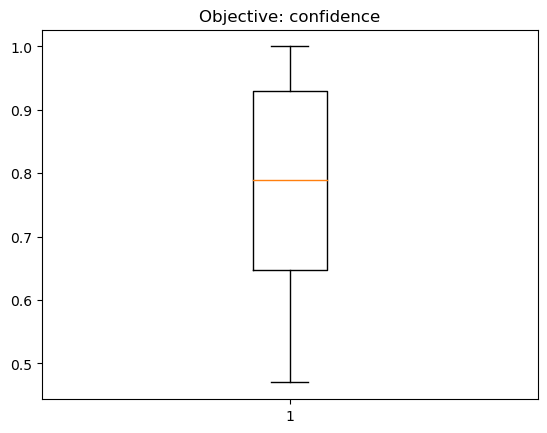

In [142]:
plt.boxplot(x=result_classification['objective_confidence'])
plt.title("Objective: confidence")
plt.show()

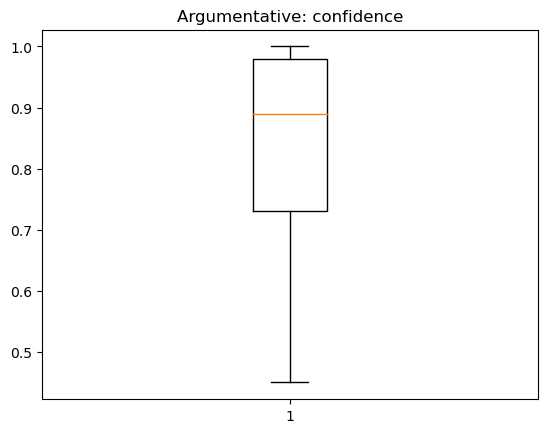

In [143]:
plt.boxplot(x=result_classification['argumentative_confidence'])
plt.title("Argumentative: confidence")
plt.show()

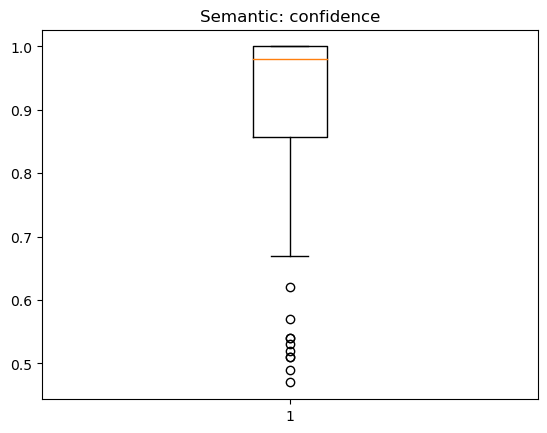

In [144]:
plt.boxplot(x=result_classification['semantic_confidence'])
plt.title("Semantic: confidence")
plt.show()

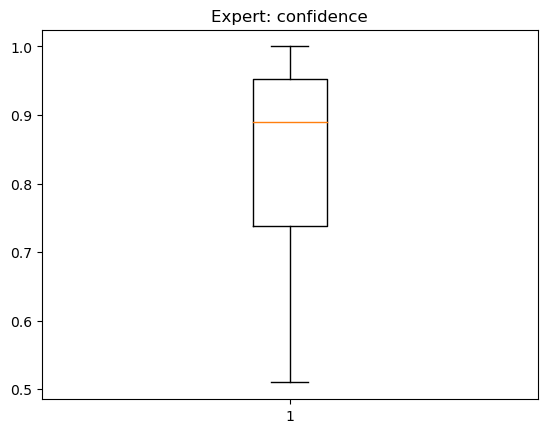

In [145]:
plt.boxplot(x=result_classification['expert_confidence'])
plt.title("Expert: confidence")
plt.show()

In [112]:
num_params = ['objective', 'argumentative',  'expert']

np.sum(result_classification[num_params] == 'maybe', axis=0)/100

objective        0.67
argumentative    0.00
expert           0.85
dtype: float64

In [113]:
np.sum(result_classification[num_params] == 'true', axis=0)/100

objective        0.31
argumentative    0.24
expert           0.00
dtype: float64

In [114]:
np.sum(result_classification[num_params] == 'false', axis=0)/100

objective        0.02
argumentative    0.76
expert           0.15
dtype: float64

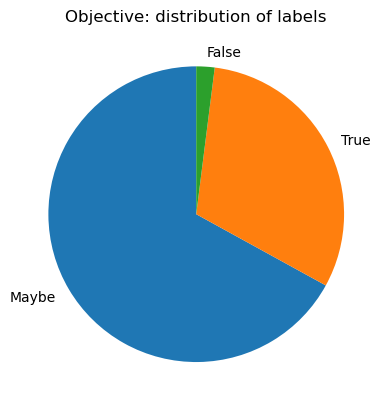

In [122]:
y = np.array([0.67, 
               0.31, 
              0.02])
mylabels = ["Maybe", "True", "False"]

plt.pie(y, labels = mylabels, startangle = 90)
plt.title("Objective: distribution of labels")
plt.show() 

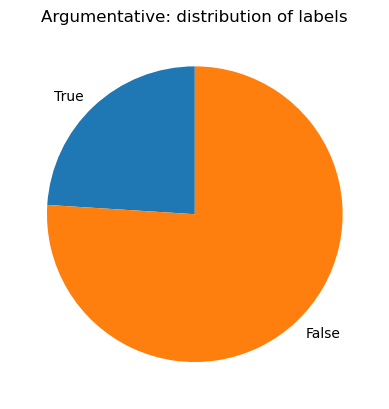

In [125]:
y = np.array([ 
                0.24, 
               0.76])
mylabels = ["True", "False"]

plt.pie(y, labels = mylabels, startangle = 90)
plt.title("Argumentative: distribution of labels")
plt.show() 

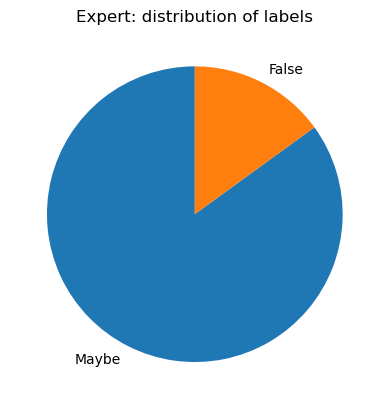

In [126]:
y = np.array([0.85,  
              0.15])
mylabels = ["Maybe", "False"]

plt.pie(y, labels = mylabels, startangle = 90)
plt.title("Expert: distribution of labels")
plt.show() 

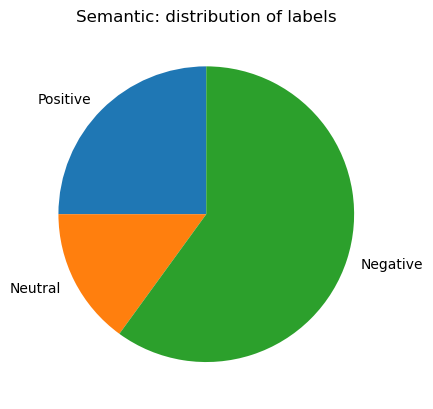

In [121]:
y = np.array([np.sum(result_classification['semantic'] == 'positive', axis=0)/100, 
              np.sum(result_classification['semantic'] == 'neutral', axis=0)/100, 
              np.sum(result_classification['semantic'] == 'negative', axis=0)/100])
mylabels = ["Positive", "Neutral", "Negative"]

plt.pie(y, labels = mylabels, startangle = 90)
plt.title("Semantic: distribution of labels")
plt.show() 

In [119]:
result_classification.to_excel("classification.xlsx")  

# Check halucination

In this part, we would prompt ChatGpt if there is enough information to answer the question

In [ ]:
questions = [
    'Is author objective (which means that he is realistic and not overpesimistic/overoptimistic)?',
    'Is author comment argumentative (which means that author throughtly discusses the risk)?',
    'What is the semantic of comment?',
    'Is author is an expert in risk analysis and have enough expertise to judge about this risk?'
]

PROMPT = """
You will be given a comment about given risk type and either impact or dimension of the risk. You will be given also a question about the comment.
Before even answering the question, consider whether you have sufficient information to answer the question.
Respond with just one word, the boolean true or false. You must output the word 'True', or the word 'False', nothing else. Respond 'True' if there is enough information and 'False' if it is not enough.
Comment: {comment}, Question: {question}
"""

result_hallucination = {
    'comment': [],
    'objective_enough_information':[],
    'objective_enough_information_confidence':[],
    'argumentative_enough_information':[],
    'argumentative_enough_information_confidence':[],
    'semantic_enough_information':[],
    'semantic_enough_information_confidence':[],
    'expert_enough_information':[],
    'expert_enough_information_confidence':[],

}

for i, comment in enumerate(list_comment):
    print(f"comment: {values[i][3]}")
    result_hallucination['comment'].append(values[i][3])
    for question, p in zip(questions, params):
        API_RESPONSE = get_completion(
            [
                {
                    "role": "user",
                    "content": PROMPT.format(
                        comment=comment, question=question
                    ),
                }
            ],
            model="gpt-4-turbo",
            logprobs=True,
        )
        for logprob in API_RESPONSE.choices[0].logprobs.content:

            prob = np.round(np.exp(logprob.logprob),2)
            result_hallucination[p+"_enough_information"].append(logprob.token)
            result_hallucination[p+"_enough_information_confidence"].append(prob)
            
            print(f"enough information for {p}: {logprob.token}, p={prob}")

result_hallucination = pd.DataFrame(result_hallucination)

In [106]:
num_params = ['objective_enough_information', 'argumentative_enough_information', 'semantic_enough_information', 'expert_enough_information']
np.sum(result_hallucination[num_params]=="True")/100

objective_enough_information        0.00
argumentative_enough_information    0.23
semantic_enough_information         0.02
expert_enough_information           0.00
dtype: float64

In [108]:
num_params = ['objective_enough_information_confidence', 'argumentative_enough_information_confidence', 'semantic_enough_information_confidence', 'expert_enough_information_confidence']
np.mean(result_hallucination[num_params], axis=0)

objective_enough_information_confidence        0.9910
argumentative_enough_information_confidence    0.8867
semantic_enough_information_confidence         0.9442
expert_enough_information_confidence           1.0000
dtype: float64

In [102]:
result_hallucination.to_excel("hallucination.xlsx")  

# Study hallucination on the produced "analysis" paragraphs

We would take a subset of comments and for each generate sample analysis paragraph 10 times. In order to study the effect of hallucination we would refer to the other paper about SelfChechGPT.

In [ ]:
# run this cell to install the required library related to selfcheckgpt

torch.manual_seed(28)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [79]:
list_comment = []
for i in range(10):
    list_comment.append(f"The comment is about {values[i][0]} and author discusses {values[i][1]} of this risk. It graded {values[i][1]} of the risk as {temp[i]} and argumented it by saying: {values[i][3]}")


PROMPT =  """Assistant is an expert in risk analysis and linguistics, so based on the comment it can evaluate parameters associated with text features. 
            It can make conclusions only based on the provided comment. The assistant would be provided some information about the author and its opinion 
            as comment. Comment itself is about some risk type and discusses other impact or likelyhood of risk type. Author comments how likely or
            impactful the risk type and explains why he/she thinks so by giving additional comment. Return only answer to the question and nothing else. 
            MAKE SURE that the language style of the assistant answer should be clear and consistent, it should contain all the information asked in the question 
            without unnecessary and vague words. 
Comment: {comment}\nQuestion:{question}"""

QUESTION = """
    Provide analysis of the comment. The analysis should contain answers to these questions:
    - Is author objective (which means that he is realistic and not overpesimistic/overoptimistic)?\n
    - Is author comment argumentative (which means that author throughtly discusses the risk)?\n
    - What is the semantic of comment? Is it negative/positive or neutral\n
    - Is author is an expert in risk analysis and have enough expertise to judge about this risk?\n

    Analysis should be through out and assistant should support the analysis with proper reasoning: why assistant thinks so. 
    Provide exactly 4 sentences and each sentence should be related to only one question. The analysis should be based only on the comment. 
    It should be a consistent paragraph.
"""

In [80]:
full = []

for j in range(10):
    results_hallucinations_analysis = []
    for i in range(5):
        API_RESPONSE = get_completion(
                    [
                        {
                            "role": "user",
                            "content": PROMPT.format(
                                comment=list_comment[j], question=QUESTION
                            ),
                        }
                    ],
                    model="gpt-4-turbo",
        )
        results_hallucinations_analysis.append(API_RESPONSE.choices[0].message.content)
    full.append(results_hallucinations_analysis)

In [ ]:
selfcheck_mqag = SelfCheckMQAG(device=device)

full_sent_scores_mqag = []
for val in full:
    passage = val[0]
    sentences = [sent for sent in nlp(passage).sents] # List[spacy.tokens.span.Span]
    sentences = [sent.text.strip() for sent in sentences if len(sent) > 3]

    sent_scores_mqag = selfcheck_mqag.predict(
        sentences,
        passage,
        val[1:],
        num_questions_per_sent = 3,
        scoring_method = 'bayes_with_alpha',
        beta1 = 0.95, beta2 = 0.95,
    )
    full_sent_scores_mqag.append(sent_scores_mqag)

In [96]:
np.mean(full_sent_scores_mqag, axis=0)

array([0.202977  , 0.17699782, 0.31384664, 0.28041832])

In [97]:
np.mean(full_sent_scores_mqag, axis=1)

array([0.36946767, 0.25449965, 0.20165467, 0.36989242, 0.23346918,
       0.27607643, 0.23686838, 0.19244425, 0.1719234 , 0.12930342])

In [ ]:
selfcheck_bertscore = SelfCheckBERTScore()

full_sent_scores_bertscore  = []

for val in full:
     
    passage = val[0]
    sentences = [sent for sent in nlp(passage).sents] # List[spacy.tokens.span.Span]
    sentences = [sent.text.strip() for sent in sentences if len(sent) > 3]

    sent_scores_bertscore = selfcheck_bertscore.predict(
        sentences,
        val[1:],
    )
    full_sent_scores_bertscore.append(sent_scores_bertscore)


In [94]:
np.mean(full_sent_scores_bertscore, axis=0)

array([0.2373552 , 0.23469957, 0.27987769, 0.32700298])

In [95]:
np.mean(full_sent_scores_bertscore, axis=1)

array([0.21768337, 0.23349284, 0.17058495, 0.36652943, 0.23264605,
       0.37785101, 0.2865049 , 0.20418666, 0.35563593, 0.25222347])

In [89]:
selfcheck_ngram = SelfCheckNgram(n=1)

full_sent_scores_ngram_1  = []
for val in full:
     
    passage = val[0]
    sentences = [sent for sent in nlp(passage).sents] # List[spacy.tokens.span.Span]
    sentences = [sent.text.strip() for sent in sentences if len(sent) > 3]

    sent_scores_ngram = selfcheck_ngram.predict(
        sentences = sentences,   
        passage = passage,
        sampled_passages = val[1:],
    )
    full_sent_scores_ngram_1.append(sent_scores_ngram)

SelfCheck-1gram initialized


In [90]:
full_sent_scores_ngram_1

[{'sent_level': {'avg_neg_logprob': [4.654363838878966,
    4.141203015733941,
    4.386247005632647,
    4.584196141300706],
   'max_neg_logprob': [5.872117789475416,
    5.466652681367251,
    6.565264970035361,
    5.872117789475416]},
  'doc_level': {'avg_neg_logprob': 4.453931447084157,
   'avg_max_neg_logprob': 5.944038307588361}},
 {'sent_level': {'avg_neg_logprob': [4.362502680827345,
    4.52412411838196,
    4.473797416791533,
    4.228133238521404],
   'max_neg_logprob': [5.72194977861165,
    6.415096959171596,
    5.72194977861165,
    5.316484670503486]},
  'doc_level': {'avg_neg_logprob': 4.403170283687779,
   'avg_max_neg_logprob': 5.793870296724595}},
 {'sent_level': {'avg_neg_logprob': [4.2199034183681245,
    4.222427625514441,
    3.977922024725828,
    4.528586173207753],
   'max_neg_logprob': [5.079850363117729,
    6.466144724237619,
    6.466144724237619,
    6.466144724237619]},
  'doc_level': {'avg_neg_logprob': 4.24431318282453,
   'avg_max_neg_logprob': 6.11

In [99]:
l = []
for i in full_sent_scores_ngram_1:
    l.append(i['sent_level']['avg_neg_logprob'])


In [101]:
np.mean(l, axis = 0)

array([4.41124356, 4.318532  , 4.35048047, 4.49826405])